In [1]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt

## Approach:
* **Data Processing**:
We are converting the audio file into MEL Spectogram. We consider only first 30 sec as fixed duration for each file. 
Also, we are converting MEL form into Decibel scale.
* **Data Split**:
We considered 80-10-10 split. We train our model on 80% data set, we use 10% data as Validation set and 10% data as Test set.
* **Model Configuration**:
We apply CNN on converted **mel_db** feature. 

**CNN Configuration**:

* 3 Conv → ReLU → BatchNorm → MaxPool blocks

* Adaptive average pooling → compresses to fixed-size

* Final Linear layer for class prediction

In [2]:
# === CONFIGURATION ===
SAMPLE_RATE = 22050
NUM_MELS = 64
FIXED_DURATION_SEC = 30
FIXED_NUM_SAMPLES = SAMPLE_RATE * FIXED_DURATION_SEC
BATCH_SIZE = 16
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset Processing:

In [3]:
# Padding or Cropping based on target length
def pad_or_crop(waveform, target_len):
    if waveform.size(1) > target_len:
        return waveform[:, :target_len]
    elif waveform.size(1) < target_len:
        pad_len = target_len - waveform.size(1)
        return torch.nn.functional.pad(waveform, (0, pad_len))
    return waveform

In [4]:
# === DATASET ===
class GenreDataset(Dataset):
    def __init__(self, filepaths, labels):
        self.filepaths = filepaths
        self.labels = labels
        self.mel_transform = MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=NUM_MELS)
        self.db_transform = AmplitudeToDB()

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        path = self.filepaths[idx]
        label = self.labels[idx]

        waveform, sr = torchaudio.load(path)
        if sr != SAMPLE_RATE:
            waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)

        waveform = pad_or_crop(waveform, FIXED_NUM_SAMPLES)

        mel = self.mel_transform(waveform)
        mel_db = self.db_transform(mel)

        return mel_db, label

## Model Configuration

In [5]:
# === MODEL ===
class CNNGenreClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

## Data Split

In [6]:
# === DATA SPLITTING ===
def prepare_data(data_dir):
    filepaths, labels = [], []

    for genre in os.listdir(data_dir):
        genre_path = os.path.join(data_dir, genre)
        if not os.path.isdir(genre_path):
            continue
        for file in os.listdir(genre_path):
            if file.endswith(".au"):
                filepaths.append(os.path.join(genre_path, file))
                labels.append(genre)

    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    joblib.dump(encoder, "/kaggle/working/genre_encoder.pkl")

    # 80% train, 20% temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        filepaths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
    )

    # Split 20% temp → 10% val, 10% test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    return X_train, y_train, X_val, y_val, X_test, y_test, len(set(labels)), encoder

## Training Function

In [7]:
# === TRAINING FUNCTION ===
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

## Validation

In [8]:
# === EVALUATION FUNCTION ===
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

## Audio Spectogram Visualization

In [9]:
# === VISUALIZE MEL SPECTROGRAM ===
def visualize_mel(file_path):
    waveform, sr = torchaudio.load(file_path)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)
    waveform = pad_or_crop(waveform, FIXED_NUM_SAMPLES)
    mel = MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=NUM_MELS)(waveform)
    mel_db = AmplitudeToDB()(mel)

    plt.figure(figsize=(10, 4))
    plt.imshow(mel_db.squeeze().numpy(), aspect='auto', origin='lower', cmap='inferno')
    plt.colorbar(label='dB')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency Bin")
    plt.tight_layout()
    plt.show()

## Training and Validation:

In [10]:
def train_validation_loop(model, num_epochs=20, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr)
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        loss = train(model, train_loader, criterion, optimizer)
        train_acc = evaluate(model, train_loader)
        val_acc = evaluate(model, val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "/kaggle/working/genre_classifier_best.pth")
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

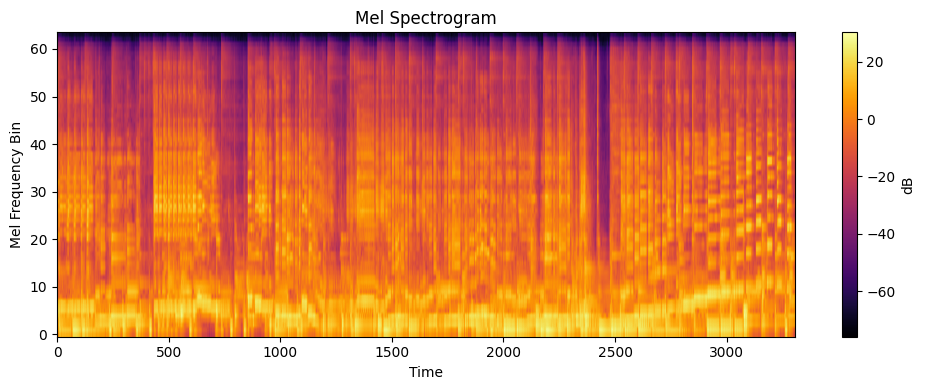

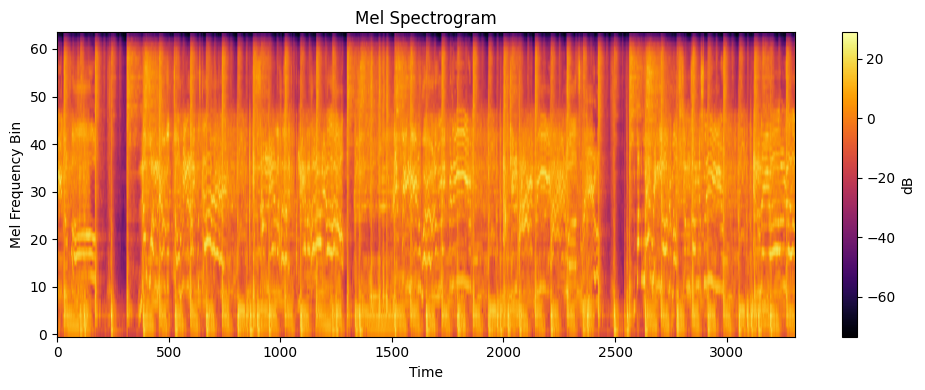

In [11]:
#Preparing dataloaders
data_dir = '/kaggle/input/audiodata/genres'
X_train, y_train, X_val, y_val, X_test, y_test, num_classes, encoder = prepare_data(data_dir)

train_dataset = GenreDataset(X_train, y_train)
val_dataset = GenreDataset(X_val, y_val)
test_dataset = GenreDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Visualize one Mel Spectrogram for train data point
visualize_mel(X_train[0])

# Visualize one Mel Spectrogram for test data point
visualize_mel(X_test[0])

In [12]:
#Model initialization
model = CNNGenreClassifier(num_classes).to(DEVICE)

#Training & Validation Invocation
train_validation_loop(model,num_epochs=50)

#Loading best model trained
model.load_state_dict(torch.load('/kaggle/working/genre_classifier_best.pth'))

# Final test accuracy
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

Epoch 1/50 - Loss: 2.0599 | Train Acc: 32.25% | Val Acc: 32.00%
Epoch 2/50 - Loss: 1.8150 | Train Acc: 42.00% | Val Acc: 41.00%
Epoch 3/50 - Loss: 1.6771 | Train Acc: 44.50% | Val Acc: 47.00%
Epoch 4/50 - Loss: 1.5637 | Train Acc: 44.62% | Val Acc: 42.00%
Epoch 5/50 - Loss: 1.4929 | Train Acc: 49.88% | Val Acc: 51.00%
Epoch 6/50 - Loss: 1.4616 | Train Acc: 54.38% | Val Acc: 47.00%
Epoch 7/50 - Loss: 1.4021 | Train Acc: 53.50% | Val Acc: 52.00%
Epoch 8/50 - Loss: 1.3688 | Train Acc: 53.75% | Val Acc: 52.00%
Epoch 9/50 - Loss: 1.3197 | Train Acc: 60.38% | Val Acc: 61.00%
Epoch 10/50 - Loss: 1.2920 | Train Acc: 60.88% | Val Acc: 61.00%
Epoch 11/50 - Loss: 1.2262 | Train Acc: 56.75% | Val Acc: 56.00%
Epoch 12/50 - Loss: 1.1951 | Train Acc: 50.50% | Val Acc: 55.00%
Epoch 13/50 - Loss: 1.1587 | Train Acc: 65.38% | Val Acc: 59.00%
Epoch 14/50 - Loss: 1.1462 | Train Acc: 58.00% | Val Acc: 57.00%
Epoch 15/50 - Loss: 1.1221 | Train Acc: 63.88% | Val Acc: 64.00%
Epoch 16/50 - Loss: 1.1016 | Train

In [13]:
def predict_genre(model, file_path, encoder):
    model.eval()
    waveform, sr = torchaudio.load(file_path)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)
    waveform = pad_or_crop(waveform, FIXED_NUM_SAMPLES)

    mel = MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=NUM_MELS)(waveform)
    mel_db = AmplitudeToDB()(mel)

    input_tensor = mel_db.unsqueeze(0).to(DEVICE)  # Add batch dim
    with torch.no_grad():
        output = model(input_tensor)
        predicted_index = torch.argmax(output, dim=1).item()

    predicted_label = encoder.inverse_transform([predicted_index])[0]
    print(f"🎶 Predicted Genre: **{predicted_label}**")
    return predicted_label


In [14]:
# Load model
num_classes = 10
model = CNNGenreClassifier(num_classes)
model.load_state_dict(torch.load("/kaggle/working/genre_classifier_best.pth"))
model.to('cuda' if torch.cuda.is_available() else 'cpu')
#Load encoder
encoder = joblib.load("genre_encoder.pkl")

In [15]:
file_path='/kaggle/input/audiodata/genres/blues/blues.00006.au'

In [16]:
# Predict
predict_genre(model,file_path, encoder)

🎶 Predicted Genre: **blues**


'blues'

In [17]:
file_path='/kaggle/input/audiodata/genres/disco/disco.00006.au'

In [18]:
# Predict
predict_genre(model,file_path, encoder)

🎶 Predicted Genre: **disco**


'disco'

## Observations:

* Model gives 75% accuracy on Test data set, when we try to randomly predict a audio data, it correctly predicts the input.
* May be we can train for more number of iterations or try to tweak the model configuration to get more test performance.
